explore the data model, or the likelihood
use deterministic plankton model (with built-in in ODE solver)

In [1]:
rm(list=ls())
library(deSolve)

In [2]:
simulate <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    om <- 2*pi/365
    dP <- gamma*(1+sin(om*t))*P - lambda*P^2
    list(c(dP))
  })
}

In [3]:
loglike <- function(theta,obs)
{
  # step 1: run the model given the parameters to get state
  tobs <- obs[,1]
  yobs <- obs[,2]
  state <- c(P = 2.5)
  out <- ode(y = state, times = tobs, func = simulate, parms = theta)
  time <- out[,1]
  xhat <- out[,2]  
  # step 2: compute the likelihood ( compare state to observations)
  L <- -sum((yobs-xhat)^2)
}

Generate Synthetic Observations

make up some synthetic (~biweekly) observations

i.e., simulate P, extract every 15th day, add some white noise

In [4]:
T     <- 365*4
theta <- c(gamma = .25, lambda = .1)
state <- c(P = 2.5)
times <- seq(0, T, by = 15)
out   <- ode(y = state, times = times, func = simulate, parms = theta)
tobs <- out[,1]
x    <- out[,2]
yobs <- x + 0.3*rnorm(length(x))

obs  <- cbind(tobs,yobs)
#save(tobs,yobs,file="obs.RData")

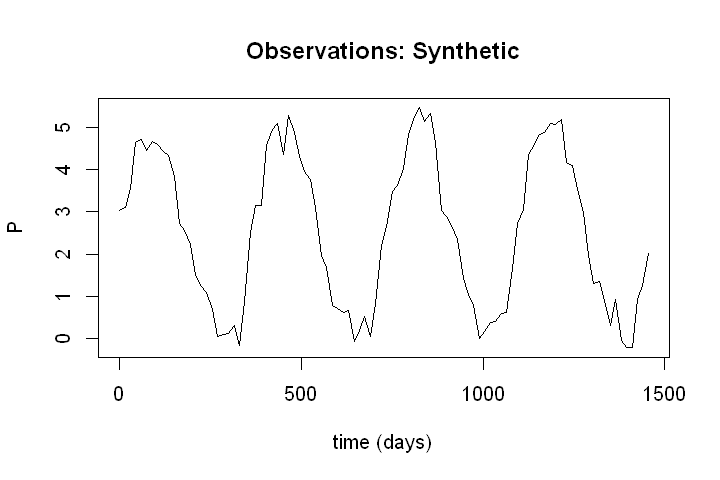

In [5]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(1,1))
plot(tobs,yobs,type="l", main="Observations: Synthetic", xlab="time (days)", ylab="P")

In [6]:
#################
# LIKELIHOOD 

####### spot likelihood value ########
# how probable is the set of parameters?

# Specify the parameters
theta <- c(gamma = .2, lambda = .15)
# Compute likelihood

L <- loglike(theta,obs)
print(L)

[1] -221.4523


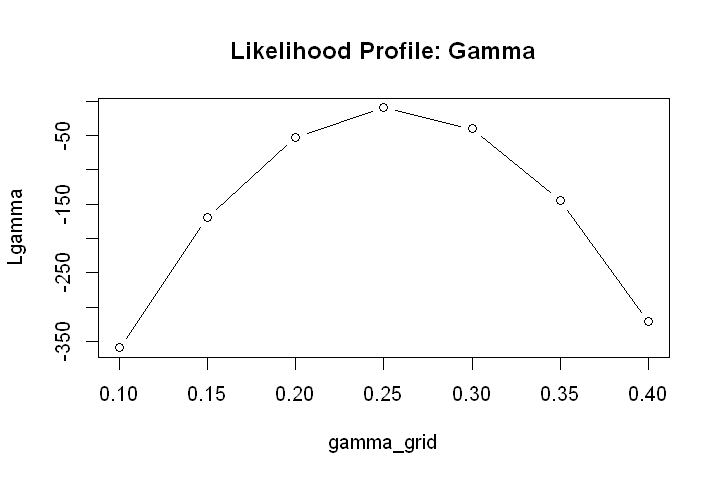

In [7]:
###### Likelihood Profiles ######
# profile each parameter separately, fix other param at "true" value

theta <- c(gamma = .25, lambda = .1)

# gamma
gamma_grid <- seq(0.1,0.4,0.05)
ng <- length(gamma_grid)
Lgamma <- array(NA,ng)
for (k in 1:ng){
  theta[1] <- gamma_grid[k]
  Lgamma[k] <- loglike(theta,obs)
}
plot(gamma_grid,Lgamma,type="b",main="Likelihood Profile: Gamma")

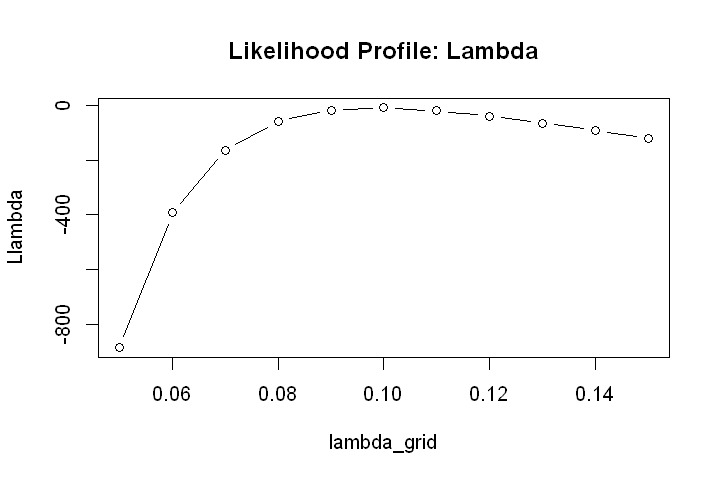

In [8]:
theta <- c(gamma = .25, lambda = .1)

lambda_grid <- seq(0.05,0.15,0.01)
nl <- length(lambda_grid)
Llambda <- array(NA,nl)
for (k in 1:nl){
  theta[2] <- lambda_grid[k]
  Llambda[k] <- loglike(theta,obs)
}
plot(lambda_grid,Llambda,type="b",main="Likelihood Profile: Lambda")

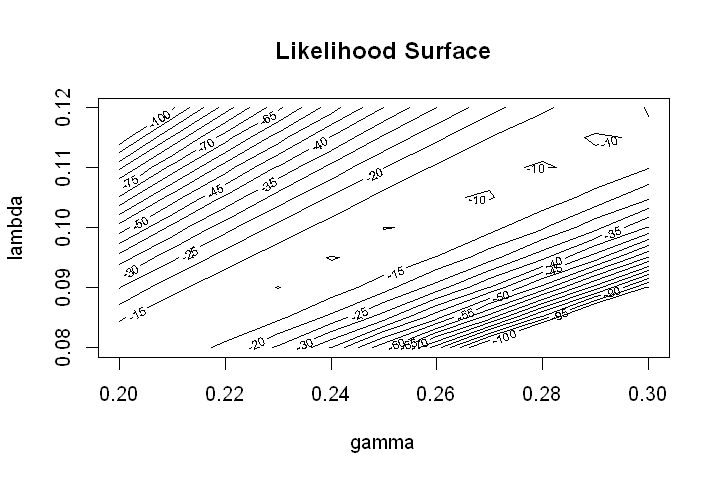

In [9]:
# 2D likelihood
# show image or contour plot
gamma_grid <- seq(0.2,0.3,0.01)
ng <- length(gamma_grid)
lambda_grid <- seq(0.08,0.12,0.005)
nl <- length(lambda_grid)

Lacc <- array(NA,dim=c(ng,nl))

for (i in 1:ng){
  for (j in 1:nl){
    #theta <- c(gamma_grid[i], lambda_grid[j])
    theta <- c(gamma = gamma_grid[i], lambda = lambda_grid[j])
    Lacc[i,j] = loglike(theta,obs) 
  }
}

#image(gamma_grid,lambda_grid,Lacc, zlim=c(0,500))
contour(gamma_grid,lambda_grid,Lacc, 
        levels=seq(-100,0,5), 
        main="Likelihood Surface", xlab="gamma", ylab="lambda")

In [10]:
MLE <- optim(c(gamma = .25, lambda = .1), loglike, obs=obs, hessian=T, control=list(fnscale=-1))
MLE

,gamma,lambda
gamma,-23354.81,58791.98
lambda,58791.98,-148920.10
